In [8]:
import cv2
import numpy as np
import os
from ultralytics import SAM, FastSAM
from ultralytics.models.fastsam import FastSAMPrompt, FastSAMPredictor
from matplotlib import pyplot as pp
from matplotlib.image import imread
from PIL import Image

In [3]:
image_path = "E:\\Dataset Multispectral\\Dataset_Mapir\\NormalRGN_Unpad\\2024_0615\\A4.JPG"

In [4]:
def check_image_path(image_path):
  """
  Checks if the given image path exists.

  Args:
      image_path: Path to the image file.

  Returns:
      True if the path exists, False otherwise.
  """
  return os.path.exists(image_path)

# Example usage
if check_image_path(image_path):
  print(f"Image path exists: {image_path}")
else:
  print(f"Image path does not exist: {image_path}")

Image path exists: E:\Dataset Multispectral\Dataset_Mapir\NormalRGN_Unpad\2024_0615\A4.JPG


In [5]:
# Load a model
model = FastSAM("FastSAM-x.pt")

# Run inference on an image
results = model(image_path, device="cpu", retina_masks=True, imgsz=1024, conf=0.7, iou=0.9)

# Prepare a Prompt Process object
prompt_process = FastSAMPrompt(image_path, results, device="cpu")

# Text prompt
ann = prompt_process.text_prompt(text="leaves of a plant")


image 1/1 E:\Dataset Multispectral\Dataset_Mapir\NormalRGN_Unpad\2024_0615\A4.JPG: 768x1024 16 objects, 8914.2ms
Speed: 16.6ms preprocess, 8914.2ms inference, 3453.8ms postprocess per image at shape (1, 3, 768, 1024)


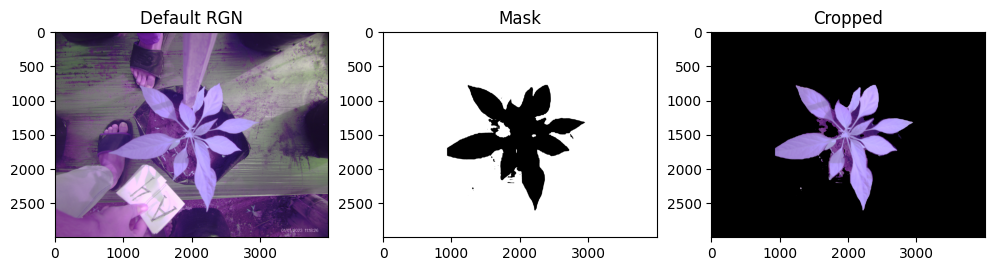

In [11]:
image = imread(image_path)
mask = ann[0].masks.data.cpu().squeeze()

cropped = image.copy()
cropped[mask == 0] = 0

pp.figure(figsize=(12,5))
pp.subplot(1,3,1)
pp.title('Default RGN')
pp.imshow(image)
pp.subplot(1,3,2)
pp.title('Mask')
pp.imshow(mask, cmap='binary')
pp.subplot(1,3,3)
pp.title('Cropped')
pp.imshow(cropped)

In [ ]:
prompt_process.plot(annotations=ann, output="E:\\Dataset Multispectral\\Dataset_Mapir")

Saving F4.JPG to E:\Dataset Multispectral\Dataset_Mapir\F4.JPG: 100%|██████████| 1/1 [00:07<00:00,  7.72s/it]


In [ ]:
output_path = "E:\\Dataset Multispectral\\Dataset_Mapir\\OutputTest"

# Generate the output filename
base_filename = os.path.basename(image_path)
output_filename = os.path.join(output_path, base_filename)

# Save the cropped image as a .jpg file
cropped_image = Image.fromarray((cropped * 255).astype(np.uint8))  # Ensure the image is in uint8 format
cropped_image.save(output_filename, format='JPEG')

 Automatic Dataset Generator Mask with FastSAM

In [2]:
# Define input and output directories
input_dir = "E:\\Dataset Multispectral\\Dataset_Mapir\\NormalRGN_Unpad\\2024_0622"
output_dir = "E:\\Dataset Multispectral\\Dataset_Mapir\\OutputTest"
# output_dir = "E:\\Dataset Multispectral\\Dataset_Mapir\\MaskevdRGN_Unpad"

model = FastSAM("FastSAM-x.pt")

# Function to process each image
def process_image(image_path, output_path, model):
    # Run inference on the image
    results = model(image_path, device="cpu", retina_masks=True, imgsz=1024, conf=0.7, iou=0.9)

    # Prepare a Prompt Process object
    prompt_process = FastSAMPrompt(image_path, results, device="cpu")

    # Text prompt
    ann = prompt_process.text_prompt(text="leaves of a plant")

    # Load the image
    image = imread(image_path)
    mask = ann[0].masks.data.cpu().squeeze().numpy()

    # Create a new result image where the mask is applied to the original image
    cropped = image.copy()
    cropped[mask == 0] = 0  # Set pixels outside the mask to black

    # Create the output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Extract the filename from the image path and create the output path
    filename = os.path.basename(image_path)
    output_file = os.path.join(output_path, filename)

    # Save the cropped image as .jpg file
    cropped_image = Image.fromarray(mask)
    cropped_image.save(output_file, format='JPEG')

# Iterate through all files in the input directory
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(input_dir, filename)
        process_image(image_path, output_dir, model)
        print(f"Processed and saved: {image_path}")


image 1/1 E:\Dataset Multispectral\Dataset_Mapir\NormalRGN_Unpad\2024_0622\A1.JPG: 768x1024 11 objects, 8949.1ms
Speed: 15.1ms preprocess, 8949.1ms inference, 2104.9ms postprocess per image at shape (1, 3, 768, 1024)
Processed and saved: E:\Dataset Multispectral\Dataset_Mapir\NormalRGN_Unpad\2024_0622\A1.JPG

image 1/1 E:\Dataset Multispectral\Dataset_Mapir\NormalRGN_Unpad\2024_0622\A10.JPG: 768x1024 12 objects, 8860.5ms
Speed: 9.6ms preprocess, 8860.5ms inference, 2253.8ms postprocess per image at shape (1, 3, 768, 1024)
Processed and saved: E:\Dataset Multispectral\Dataset_Mapir\NormalRGN_Unpad\2024_0622\A10.JPG

image 1/1 E:\Dataset Multispectral\Dataset_Mapir\NormalRGN_Unpad\2024_0622\A11.JPG: 768x1024 14 objects, 8674.5ms
Speed: 9.6ms preprocess, 8674.5ms inference, 2574.2ms postprocess per image at shape (1, 3, 768, 1024)
Processed and saved: E:\Dataset Multispectral\Dataset_Mapir\NormalRGN_Unpad\2024_0622\A11.JPG

image 1/1 E:\Dataset Multispectral\Dataset_Mapir\NormalRGN_Unpad

KeyboardInterrupt: 

.JPG to YOLO FORMAT .txt

In [5]:
import os
import cv2
import numpy as np
import glob

def create_yolo_format(data_dir, image_dir, mask_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    image_paths = glob.glob(os.path.join(image_dir, '*.jpg'))
    
    for image_path in image_paths:
        image_name = os.path.basename(image_path)
        mask_path = os.path.join(mask_dir, image_name)  # Assume mask has the same name and jpg extension

        # Read image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, 0)  # Read as grayscale

        # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Image dimensions
        height, width = image.shape[:2]

        yolo_annotations = []

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            x_center = (x + w / 2) / width
            y_center = (y + h / 2) / height
            bbox_width = w / width
            bbox_height = h / height

            yolo_annotations.append(f"0 {x_center} {y_center} {bbox_width} {bbox_height}")

        # Write YOLO annotations to file
        annotation_path = os.path.join(output_dir, image_name.replace('.jpg', '.TXT'))
        with open(annotation_path, 'w') as f:
            f.write('\n'.join(yolo_annotations))

data_dir = 'E:\\Dataset Multispectral\\Dataset_Mapir\\segmentation\\train'
image_dir = os.path.join(data_dir, 'images')
mask_dir = os.path.join(data_dir, 'masks')
output_dir = os.path.join(data_dir, 'labels')

create_yolo_format(data_dir, image_dir, mask_dir, output_dir)


In [5]:
import os
import cv2
import glob

def create_yolo_segmentation_format(image_dir, mask_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    image_paths = glob.glob(os.path.join(image_dir, '*.JPG'))
    
    for image_path in image_paths:
        image_name = os.path.basename(image_path)
        mask_path = os.path.join(mask_dir, image_name.replace('.JPG', '.JPG'))  # Assuming masks are in JPG format

        # Read image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, 0)  # Read as grayscale

        # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Image dimensions
        height, width = image.shape[:2]

        yolo_annotations = []

        for contour in contours:
            segmentation = []
            for point in contour:
                x, y = point[0]
                segmentation.append(x / width)
                segmentation.append(y / height)

            yolo_annotations.append(f"0 {' '.join(map(str, segmentation))}")

        # Write YOLO annotations to file
        annotation_path = os.path.join(output_dir, image_name.replace('.JPG', '.txt'))
        with open(annotation_path, 'w') as f:
            f.write('\n'.join(yolo_annotations))

image_dir = 'E:\Dataset Multispectral\Dataset_Mapir\segmentation\\val\images'
mask_dir = 'E:\Dataset Multispectral\Dataset_Mapir\masks val'
output_dir = 'E:\Dataset Multispectral\Dataset_Mapir\segmentation\\val\labels'

create_yolo_segmentation_format(image_dir, mask_dir, output_dir)


In [13]:
import cv2
import os

def convert_masks_to_yolo(mask_path, output_path):
    for fname in os.listdir(mask_path):
        if fname.endswith(".JPG"):
            # Load image
            img = cv2.imread(os.path.join(mask_path, fname), 0)
            # Find contours
            contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            # Convert contours to YOLO format
            with open(os.path.join(output_path, fname.split('.')[0] + ".txt"), 'w') as f:
                for cnt in contours:
                    x, y, w, h = cv2.boundingRect(cnt)
                    f.write(f"0 {(x + w / 2) / img.shape[1]} {(y + h / 2) / img.shape[0]} {w / img.shape[1]} {h / img.shape[0]}\n")

# Usage
mask_path = 'E:\Dataset Multispectral\Dataset_Mapir\masks val'
output_path = 'E:\Dataset Multispectral\Dataset_Mapir\segmentation\\val\labels'
convert_masks_to_yolo(mask_path, output_path)

In [15]:
import os
import cv2
import json
import numpy as np
import glob

def create_yolo_segmentation_format(mask_path, output_path):
    os.makedirs(output_path, exist_ok=True)
    
    for fname in os.listdir(mask_path):
        if fname.endswith(".JPG"):
            # Load mask image
            img = cv2.imread(os.path.join(mask_path, fname), 0)
            # Find contours
            contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Convert contours to YOLO segmentation format
            annotations = []
            for cnt in contours:
                segmentation = []
                for point in cnt:
                    x, y = point[0]
                    segmentation.extend([x / img.shape[1], y / img.shape[0]])
                annotations.append(f"0 {' '.join(map(str, segmentation))}")
            
            # Write to .txt file
            with open(os.path.join(output_path, fname.replace('.JPG', '.txt')), 'w') as f:
                f.write('\n'.join(annotations))

# Usage
mask_path = 'E:/Dataset Multispectral/Dataset_Mapir/masks train'
output_path = 'E:/Dataset Multispectral/Dataset_Mapir/segmentation/train/labels'
create_yolo_segmentation_format(mask_path, output_path)

Change extension .JPG to .txt

In [10]:
import os

def change_file_extension(folder_path, old_ext='.jpg', new_ext='.JPG'):
    # Get list of all files in the directory
    files = os.listdir(folder_path)
    
    for file in files:
        # Check if the file ends with the old extension
        if file.endswith(old_ext):
            # Construct full file path
            file_path = os.path.join(folder_path, file)
            # Construct new file name
            new_file_path = os.path.join(folder_path, file.replace(old_ext, new_ext))
            # Rename the file
            os.rename(file_path, new_file_path)
            print(f'Renamed: {file_path} to {new_file_path}')

# Specify the folder path
folder_path = 'E:\Dataset Multispectral\Dataset_Mapir\masks train'
change_file_extension(folder_path, old_ext='.jpg', new_ext='.JPG')


Renamed: E:\Dataset Multispectral\Dataset_Mapir\masks train\2024_0615_A1.jpg to E:\Dataset Multispectral\Dataset_Mapir\masks train\2024_0615_A1.JPG
Renamed: E:\Dataset Multispectral\Dataset_Mapir\masks train\2024_0615_A13.jpg to E:\Dataset Multispectral\Dataset_Mapir\masks train\2024_0615_A13.JPG
Renamed: E:\Dataset Multispectral\Dataset_Mapir\masks train\2024_0615_A15.jpg to E:\Dataset Multispectral\Dataset_Mapir\masks train\2024_0615_A15.JPG
Renamed: E:\Dataset Multispectral\Dataset_Mapir\masks train\2024_0615_A17.jpg to E:\Dataset Multispectral\Dataset_Mapir\masks train\2024_0615_A17.JPG
Renamed: E:\Dataset Multispectral\Dataset_Mapir\masks train\2024_0615_B14.jpg to E:\Dataset Multispectral\Dataset_Mapir\masks train\2024_0615_B14.JPG
Renamed: E:\Dataset Multispectral\Dataset_Mapir\masks train\2024_0615_B6.jpg to E:\Dataset Multispectral\Dataset_Mapir\masks train\2024_0615_B6.JPG
Renamed: E:\Dataset Multispectral\Dataset_Mapir\masks train\2024_0615_C12.jpg to E:\Dataset Multispectra

In [ ]:
import os

def change_extension(directory):
    """Changes .jpg extensions to .JPG for all files in the specified directory.

    Args:
        directory: The path to the directory containing the files.
    """

    for filename in os.listdir(directory):
        if filename.endswith(".raw"):
            old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, filename[:-4] + ".RAW")
        os.rename(old_path, new_path)

if __name__ == "__main__":
    directory = "E:\\Dataset Multispectral\\Dataset_Mapir\\NormalRGN_Unpad\\2024_0608"  # Replace with the actual directory path
    change_extension(directory)

Training with own dataset

In [1]:
from ultralytics import YOLO

data_dir = 'D:\Project\ComputerVision\dataset.yaml'
batch = 16

# Load a COCO-pretrained YOLOv8n model
model = YOLO("yolov8l-seg.pt")

# Display model information (optional)
# model.info()

# Train the model on the COCO8 example dataset for 100 epochs
results = model.train(data=data_dir, device="cpu", batch=batch, optimizer="Adam", epochs=50, imgsz=640)

# Run inference with the YOLOv8n model on the 'bus.jpg' image
results = model("E:\\Dataset Multispectral\\Dataset_Mapir\\segment_result")

New https://pypi.org/project/ultralytics/8.2.55 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.48  Python-3.10.10 torch-2.3.1+cpu CPU (Intel Core(TM) i7-9750H 2.60GHz)
engine\trainer: task=segment, mode=train, model=yolov8l-seg.pt, data=D:\Project\ComputerVision\dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=No

train: Scanning E:\Dataset Multispectral\Dataset_Mapir\segmentation\train\labels.cache... 93 images, 0 backgrounds, 0 corrupt: 100%|██████████| 93/93 [00:00<?, ?it/s]
val: Scanning E:\Dataset Multispectral\Dataset_Mapir\segmentation\val\labels.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]


Plotting labels to runs\segment\train4\labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.0005), 116 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\segment\train4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/6 [00:00<?, ?it/s]

: 

In [4]:
from ultralytics import YOLO

gambar = "E:\\Dataset Multispectral\\Dataset_Mapir\\NormalRGN_Unpad\\2024_0627\\A7.jpg"
data_best_model = "D:\\Project\\ComputerVision\\YOLO-seg results\\weights\\best.pt"
data_last_model = "D:\\Project\\ComputerVision\\YOLO-seg results\\weights\\last.pt"
batch = 16

# Load a COCO-pretrained YOLOv8n model
model = YOLO(data_best_model)

# Display model information (optional)
model.info()

results = model.predict(gambar, save=True)

YOLOv8n-seg summary: 261 layers, 3263811 parameters, 0 gradients, 12.1 GFLOPs

image 1/1 E:\Dataset Multispectral\Dataset_Mapir\NormalRGN_Unpad\2024_0627\A7.jpg: 768x1024 2 plants, 915.6ms
Speed: 21.0ms preprocess, 915.6ms inference, 31.5ms postprocess per image at shape (1, 3, 768, 1024)
Results saved to runs\segment\predict


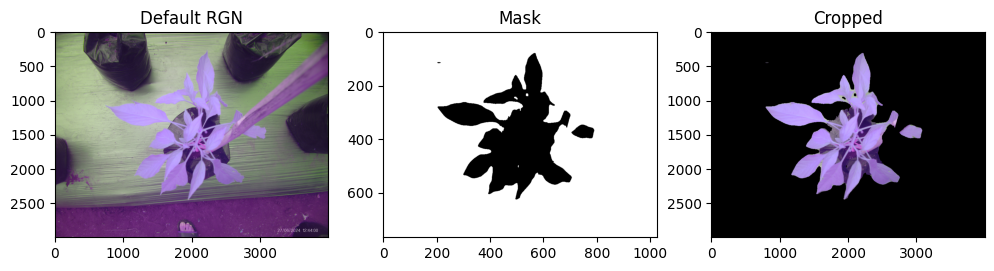

In [5]:
from matplotlib.image import imread
from PIL import Image
from matplotlib import pyplot as pp
import numpy as np

path = "E:\\Dataset Multispectral\\Dataset_Mapir\\NormalRGN_Unpad\\2024_0627\A7.jpg"
image = imread(path)

original_image = Image.open(path)
original_width, original_height = original_image.size

# Get the mask and resize it to the original image size
mask_tensor = results[0].masks.data.cpu().numpy()

# Ensure the mask is in uint8 format and has the correct shape (2D)
# Select the first mask if there are multiple
mask = (mask_tensor[0] * 255).astype(np.uint8)

# Resize the mask to match the original image dimensions
resized_mask = np.array(Image.fromarray(mask).resize((original_width, original_height), Image.NEAREST))

# Apply the mask to the image
cropped = np.copy(image)
cropped[resized_mask == 0] = 0

pp.figure(figsize=(12,5))
pp.subplot(1,3,1)
pp.title('Default RGN')
pp.imshow(image)
pp.subplot(1,3,2)
pp.title('Mask')
pp.imshow(mask, cmap='binary')
pp.subplot(1,3,3)
pp.title('Cropped')
pp.imshow(cropped)

Automatic Dataset Generator with YOLOv8

In [3]:
import os
from ultralytics import YOLO
from matplotlib.image import imread
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

input_dir = "E:\\Dataset Multispectral\\Dataset_Mapir\\NormalRGN_Unpad\\2024_0613"
output_dir = "E:\\Dataset Multispectral\\Dataset_Mapir\\OutputTest"
data_best_model = "D:\\Project\\ComputerVision\\YOLO-seg results\\weights\\best.pt"
batch = 16

# Load a COCO-pretrained YOLOv8n model
model = YOLO(data_best_model)

# Display model information (optional)
model.info()

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Process each image in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith(".JPG") or filename.endswith(".png"):  # You can add more image formats if needed
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        # Predict and save results
        results = model.predict(input_path)

        image = imread(input_path)
        original_image = Image.open(input_path)
        original_width, original_height = original_image.size

        # Get the mask and resize it to the original image size
        mask_tensor = results[0].masks.data.cpu().numpy()

        # Ensure the mask is in uint8 format and has the correct shape (2D)
        mask = (mask_tensor[0] * 255).astype(np.uint8)

        # Resize the mask to match the original image dimensions
        resized_mask = np.array(Image.fromarray(mask).resize((original_width, original_height), Image.NEAREST))

        # Apply the mask to the image
        cropped = np.copy(image)
        cropped[resized_mask == 0] = 0

        # Save the cropped image
        plt.imsave(output_path, cropped)
        print(f"Processed and saved: {output_path}")

YOLOv8n-seg summary: 261 layers, 3263811 parameters, 0 gradients, 12.1 GFLOPs

image 1/1 E:\Dataset Multispectral\Dataset_Mapir\NormalRGN_Unpad\2024_0613\kalibrasi\L1.JPG: 768x1024 1 plant, 580.6ms
Speed: 15.1ms preprocess, 580.6ms inference, 8.1ms postprocess per image at shape (1, 3, 768, 1024)
Processed and saved: E:\Dataset Multispectral\Dataset_Mapir\OutputTest\L1.JPG

image 1/1 E:\Dataset Multispectral\Dataset_Mapir\NormalRGN_Unpad\2024_0613\kalibrasi\L10.JPG: 768x1024 1 plant, 621.4ms
Speed: 8.4ms preprocess, 621.4ms inference, 8.6ms postprocess per image at shape (1, 3, 768, 1024)
Processed and saved: E:\Dataset Multispectral\Dataset_Mapir\OutputTest\L10.JPG

image 1/1 E:\Dataset Multispectral\Dataset_Mapir\NormalRGN_Unpad\2024_0613\kalibrasi\L11.JPG: 768x1024 1 plant, 580.4ms
Speed: 10.2ms preprocess, 580.4ms inference, 7.5ms postprocess per image at shape (1, 3, 768, 1024)
Processed and saved: E:\Dataset Multispectral\Dataset_Mapir\OutputTest\L11.JPG

image 1/1 E:\Dataset Mul

DICE EVALUATION

Mean Dice Coefficient: 63.80%
Mask 1: Dice Coefficient = 0.56
Mask 2: Dice Coefficient = 0.642
Mask 3: Dice Coefficient = 0.691
Mask 4: Dice Coefficient = 0.7
Mask 5: Dice Coefficient = 0.635
Mask 6: Dice Coefficient = 0.648
Mask 7: Dice Coefficient = 0.673
Mask 8: Dice Coefficient = 0.676
Mask 9: Dice Coefficient = 0.685
Mask 10: Dice Coefficient = 0.72
Mask 11: Dice Coefficient = 0.688
Mask 12: Dice Coefficient = 0.637
Mask 13: Dice Coefficient = 0.673
Mask 14: Dice Coefficient = 0.51
Mask 15: Dice Coefficient = 0.536
Mask 16: Dice Coefficient = 0.665
Mask 17: Dice Coefficient = 0.523
Mask 18: Dice Coefficient = 0.659
Mask 19: Dice Coefficient = 0.587
Mask 20: Dice Coefficient = 0.651
Mask 21: Dice Coefficient = 0.64


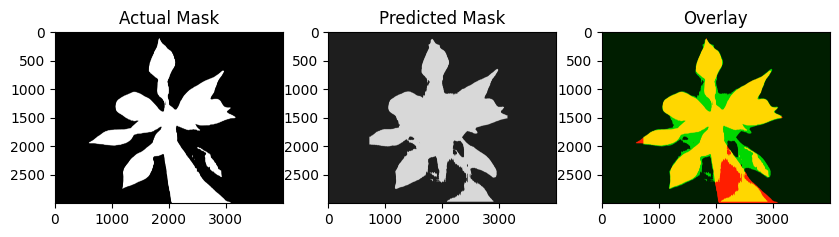

In [3]:
import os
import numpy as np
import cv2  # Ensure you have OpenCV installed: pip install opencv-python
import matplotlib.pyplot as plt

def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask * groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2 * intersect / total_sum)
    return round(dice, 3)  # round up to 3 decimal places

def load_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Assuming masks are grayscale images
    mask = mask / 255  # Normalize mask to binary values 0 or 1
    return mask

def get_mask_paths(mask_folder):
    mask_paths = []
    for filename in os.listdir(mask_folder):
        if filename.endswith('.png') or filename.endswith('.JPG'):
            mask_path = os.path.join(mask_folder, filename)
            mask_paths.append(mask_path)
    return mask_paths

def resize_mask(mask, target_size):
    return cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

def evaluate_segmentation(masks_actual_folder, masks_pred_folder):
    actual_mask_paths = get_mask_paths(masks_actual_folder)
    pred_mask_paths = get_mask_paths(masks_pred_folder)

    if len(actual_mask_paths) == 0 or len(pred_mask_paths) == 0:
        raise ValueError("No masks found in one or both directories")

    # Load one actual mask to determine the target size
    sample_actual_mask = load_mask(actual_mask_paths[0])
    target_size = (sample_actual_mask.shape[1], sample_actual_mask.shape[0])  # Width, Height

    dice_scores = []
    for actual_mask_path, pred_mask_path in zip(actual_mask_paths, pred_mask_paths):
        actual_mask = load_mask(actual_mask_path)
        pred_mask = load_mask(pred_mask_path)
        pred_mask = resize_mask(pred_mask, target_size)
        score = dice_coef(actual_mask, pred_mask)
        dice_scores.append(score)

    mean_dice = np.mean(dice_scores)
    return mean_dice, dice_scores, actual_mask_paths, pred_mask_paths

def visualize_masks(actual_mask_path, pred_mask_path):
    actual_mask = load_mask(actual_mask_path)
    pred_mask = load_mask(pred_mask_path)
    pred_mask = resize_mask(pred_mask, (actual_mask.shape[1], actual_mask.shape[0]))

    combined_mask = np.zeros((actual_mask.shape[0], actual_mask.shape[1], 3), dtype=np.uint8)

    combined_mask[..., 0] = actual_mask * 255  # Red for actual mask
    combined_mask[..., 1] = pred_mask * 255  # Green for predicted mask
    combined_mask[..., 2] = (actual_mask.astype(np.uint8) & pred_mask.astype(np.uint8)) * 255  # Yellow for overlap

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Actual Mask")
    plt.imshow(actual_mask, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(combined_mask)
    plt.show()

masks_actual_folder = 'E:\\Dataset Multispectral\\Dataset_Mapir\\Masks\\masks val'
masks_pred_folder = 'E:\\Dataset Multispectral\\Dataset_Mapir\\Masks\\masks pred'

mean_dice, dice_scores, actual_mask_paths, pred_mask_paths = evaluate_segmentation(masks_actual_folder, masks_pred_folder)
print(f'Mean Dice Coefficient: {mean_dice:.2%}')
for i, score in enumerate(dice_scores):
    print(f'Mask {i + 1}: Dice Coefficient = {score}')

# Visualize the first mask pair
visualize_masks(actual_mask_paths[5], pred_mask_paths[5])


WEB OUTPUT

In [1]:
import os
from ultralytics import YOLO
from matplotlib.image import imread
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from shutil import copy2
    
def segmentation(data_best_model, input_path ):
    # Load a COCO-pretrained YOLOv8n model
    model = YOLO(data_best_model)

    # Display model information (optional)
    model.info()
    
    results = model.predict(input_path , save=False)

    image = imread(input_path)

    original_image = Image.open(input_path )
    original_width, original_height = original_image.size

    # Get the mask and resize it to the original image size
    mask_tensor = results[0].masks.data.cpu().numpy()

    # Ensure the mask is in uint8 format and has the correct shape (2D)
    # Select the first mask if there are multiple
    mask = (mask_tensor[0] * 255).astype(np.uint8)

    # Resize the mask to match the original image dimensions
    resized_mask = np.array(Image.fromarray(mask).resize((original_width, original_height), Image.NEAREST))

    # Apply the mask to the image
    cropped = np.copy(image)
    cropped[resized_mask == 0] = 0
    
    return cropped

    
def classify(cropped_image):
    image = Image.fromarray(cropped_image.astype(np.uint8))
    image_np = np.array(image) 

    # Extract the red, green, and NIR channels
    red_channel = np.copy(image_np[:, :, 0])
    green_channel = np.copy(image_np[:, :, 1])
    nir_channel = np.copy(image_np[:, :, 2])

    red_channel = red_channel.astype(np.float32)
    green_channel = green_channel.astype(np.float32)
    nir_channel = nir_channel.astype(np.float32)

    red_channel[red_channel<170] = 0
    green_channel[green_channel<170] = 0
    nir_channel[nir_channel<170] = 0

    # Calculate NDVI with error handling for division by zero
    ndvi = (nir_channel - red_channel) / (nir_channel + red_channel)
    ndvi[np.isnan(ndvi)] = 0

    n_ndvi = np.count_nonzero(ndvi)
    x_ndvi = np.sum(ndvi)
    avg_ndvi = x_ndvi / n_ndvi if n_ndvi != 0 else 0

    if avg_ndvi <= 0:
        label = "Dead Plants"
    elif avg_ndvi <= 0.30:
        label = "Unhealthy Plants"
    elif avg_ndvi <= 0.60:
        label = "Moderately Healthy Plants"
    else:
        label = "Very Healthy Plants"

    return label, ndvi, avg_ndvi

def main():
    input_path  = "E:\\Dataset Multispectral\\Dataset_Mapir\\NormalRGN_Unpad\\SAKIT\\dead15.JPG"
    data_best_model = "D:\\Project\\ComputerVision\\YOLO-seg results\\weights\\best.pt"
    
    segment = segmentation(data_best_model, input_path )
    label, ndvi, avg_ndvi = classify(segment)
    image_data = imread(input_path)  
    
    plt.figure(figsize=(20, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(image_data)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(ndvi, cmap='gray')
    plt.title('NDVI')
    plt.axis('off')
    plt.show()
    print("NDVI avg values : ",avg_ndvi)
    print("kelas : ",label)
    

if __name__ == "__main__":
    main()

YOLOv8n-seg summary: 261 layers, 3263811 parameters, 0 gradients, 12.1 GFLOPs

image 1/1 E:\Dataset Multispectral\Dataset_Mapir\NormalRGN_Unpad\SAKIT\dead15.JPG: 768x1024 (no detections), 568.2ms
Speed: 14.1ms preprocess, 568.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


AttributeError: 'NoneType' object has no attribute 'data'

Missing file

In [2]:
import os

# Define the prefixes and number of files per prefix
prefixes = [chr(i) for i in range(ord('A'), ord('L') + 1)]
num_files_per_prefix = 18

# Generate all possible filenames
all_filenames = [f"{prefix}{i}" for prefix in prefixes for i in range(1, num_files_per_prefix + 1)]

# Assume the existing files are in a specific directory
directory = "E:\\Dataset Multispectral\\Dataset_Mapir\\NormalRGN_Unpad\\2024_0613"

# Get the list of existing files in the directory
existing_filenames = [os.path.splitext(filename)[0] for filename in os.listdir(directory)]

# Find the missing filenames
missing_filenames = [filename for filename in all_filenames if filename not in existing_filenames]

# Output the missing filenames
print("Missing filenames:")
for filename in missing_filenames:
    print(filename)


Missing filenames:
K4
